# Attempt to split available, suitable QCA datasets into data for benchmarking

Our plan here is to utilize the training molecules, along with information on chemical similarity and parameter coverage, to split the available benchmarking data into:
1. Primary sets, covering similar chemistry as training data:
   a. Test set, to be revisited potentially several times while testing
   b. Benchmark set, to be used only in assessing final FF
2. "Stretch" sets, covering more chemical diversity
   a. Test set, to be revisited potentially several times during testing
   b. Benchmark set, to be used only in assessing final FF
   
Partitioning into test and benchmark sets will be done randomly.

In this notebook we are mainly concerned about the filtering procedure to divide between primary and stretch sets.

## Big picture outline
1. Obtain training set data and potential test set data
2. Obtain parameter usage statistics for training set data (TO BE DONE) 
3. Compute chemical graph similarity matrix of all molecules
4. Cluster all molecules based on graph similarity using `DBSCAN`
5. Pick potential test set molecules as those which are in clusters with at least one training set molecule. 
6. Save molecules which are NOT in clusters with training set molecules as potential "stretch test set" molecules
7. Check parameter usage of all potential primary test set molecules; any which use especially unusual parameters get moved from test set to stretch test set (TO BE DONE)
8. Take candidate test set/stretch test set molecules and randomly partition them into test and benchmark sets (primary and stretch)



# Begin

## Begin by grabbing datasets we fit to from Yudong Qiu's releases

Specifically, we're interested in seeing which molecules are present in those sets.

Slack discussion here: https://openforcefieldgroup.slack.com/archives/C8P8MLALD/p1568325818091700. Script for extracting molecules from a release: https://github.com/lpwgroup/forcebalance-qcarchive/blob/master/analysis_scripts/find_unique_molecule_smiles.py .  Set from most recent release: https://openforcefieldgroup.slack.com/files/U8ZH3MTL2/FNBUUCADB/target_smiles.txt

In [27]:
# Load molecules used in release-1 fitting
file = open('target_smiles.txt', 'r')
text = file.readlines()
release_smi = [ line.split()[0] for line in text]


## Compute parameter usage statistics for training set molecules

Can draw on `openforcefield/utilities/deprecated/convert_frosst/parameter_usage.ipynb`

## Get available test set molecules

Note that these molecules have protonation states/tautomers enumerated so we probably have excessive representation of some molecules. Will likely want to filter to NOT have large numbers of molecules which differ only by protonation state, and to avoid unusual protonation states.


In [28]:
import sys
import os
import qcfractal.interface as ptl

from openeye.oechem import *


molecule_smiles = []
client = ptl.FractalClient()

# databases we want to search
ds_keys = [['OptimizationDataset', 'OpenFF Discrepancy Benchmark 1'], \
           ['OptimizationDataset', 'Pfizer Discrepancy Optimization Dataset 1'], \
           ['TorsionDriveDataset', 'Pfizer Discrepancy Torsion Dataset 1'], \
           ['OptimizationDataset', 'FDA Optimization Dataset 1'] ]
 
ds_smiles = []
for key in ds_keys:
    print("Loading dataset {:s} {:s} ... \n".format(*key))
    ds = client.get_collection(*key)

    rec_keys = ds.data.records.keys() #Keys look like SMILES but aren't quite

    #Retrieve actual smiles
    for key in rec_keys:
        # Retrieve canonical isomeric SMILES
        smi = ds.data.records[key].attributes['canonical_isomeric_smiles']
        # Store if not already stored (will occur multiple times because of conformers)
        if not smi in ds_smiles:
            ds_smiles.append(smi)

# This includes multiple conformers of the same molecules
print(len(ds_smiles))


Loading dataset OptimizationDataset OpenFF Discrepancy Benchmark 1 ... 

Loading dataset OptimizationDataset Pfizer Discrepancy Optimization Dataset 1 ... 

Loading dataset TorsionDriveDataset Pfizer Discrepancy Torsion Dataset 1 ... 

Loading dataset OptimizationDataset FDA Optimization Dataset 1 ... 

3871


## Collapse tautomers/protonation states

We would like to ensure we do NOT end up with, say, 100 different tautomers/protonation states of the same molecule comprising the core of our set. Or to put it another way — unless we do some collapsing of states, molecules with multiple protonation state/tautomeric states will be dramatically overrepresented in our benchmarking.

(Have not done this yet, and may not really need it at this point.)


## Filter test set molecules by similarity to chemistry of training set molecules


Here a first pass will use OEGraphSim. Since the code above is not working yet, for now let's just throw together a couple super quick sets of molecules hard-wired into this code.

### Input some datasets to play with

In [30]:
print(len(release_smi), len(ds_smiles))

1724 3871


In [32]:
# Currently I'm seeing duplicate molecules coming in from somewhere... Where?
from openeye.oechem import *

#Duplicate SMILES?
for smi in release_smi:
    if release_smi.count(smi)>1: print(release_smi.count(smi), smi)
#Nope

# Same molecule under different SMILES?
canonical_smiles = []
dupes = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    new_smi = OECreateIsoSmiString(mol)
    if new_smi in canonical_smiles:
        #print("Duplicate molecule for original SMILES string %s (canonical smiles %s)" % (smi, new_smi))
        dupes.append(smi)
    else:
        canonical_smiles.append(new_smi)
print(len(dupes))



1079


In [33]:
# Deduplicate
release_smi = canonical_smiles
print(len(release_smi))

645


### Fiddle with OEGraphSim

In [34]:
from openeye.oegraphsim import *
from openeye.oechem import *

fptype = OEFPType_Circular #I have no idea if this is best, see https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#chapter-fingerprint for options

# Make fingerprints for both sets
release_set_fp = []
release_set_mols = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    release_set_fp.append(fp)
    release_set_mols.append(mol)
    
ds_set_fp = []
ds_set_mols = []
for smi in ds_smiles:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    ds_set_fp.append(fp)
    ds_set_mols.append(mol)

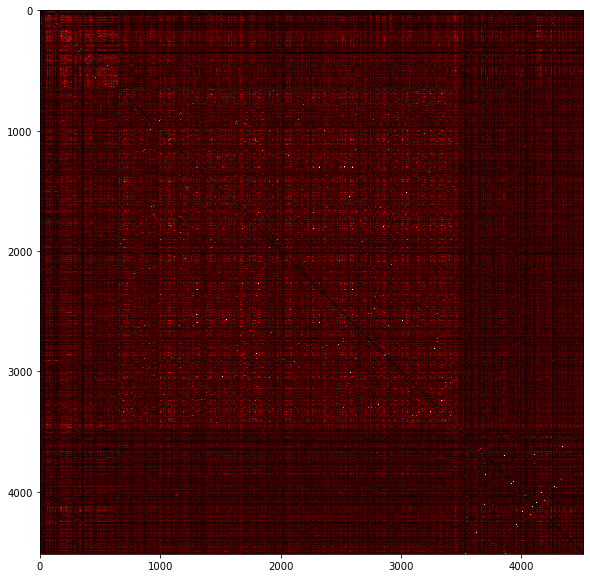

In [36]:
# Compute full similarity matrix by this OEGraphSim
# Let's make it an (N+M)*(N+M) matrix so we have all-by-all similarities.
# Make coverage set be first N, remainder next M
import numpy as np

N = len(release_smi)
M = len(ds_smiles)

t_matrix = np.zeros( (N+M,N+M), np.float)

comparison_fps = release_set_fp + ds_set_fp
comparison_mols = release_set_mols + ds_set_mols

for n in range(N+M):
    for m in range(N+M):
        if n != m: #Make diagonal elements be zero for more convenience
            t_matrix[n,m] = OETanimoto( comparison_fps[n], comparison_fps[m])

import matplotlib.pyplot as plt
%matplotlib inline

# Plot part of matrix
plt.figure(figsize =(10,10))
#plt.imshow(t_matrix[0:1000,0:1000], cmap='hot')
plt.imshow(t_matrix, cmap='hot')


### Next cluster to find things which are "alone"

In general many of our molecules are not super similar to other molecules, which is fine as long as they are built of fragments which are present in other molecules. However, what we are especially interested in is molecules which contain fragments which are not represented anywhere. To do those, we need some kind of clustering.

I might want some kind of hierarchical clustering, because what I'd like to do is not necessarily group all my molecules into clusters, but instead be able to find which molecules are similar to the least other.

DBSCAN looks interesting as it can find "noise" points which are distant from others, and doesn't take a predefined number of clusters. It also can take a precalculated distance matrix. See https://stackoverflow.com/questions/16246066/clustering-based-on-distance-matrix and https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [37]:
#Make distance matrix run from 1 being far to 0 being close rather than the opposite (Tanimoto)
dis_matrix = np.ones_like(t_matrix)-t_matrix

from sklearn.cluster import DBSCAN
from sklearn import metrics

#data_subset = dis_matrix[0:1000,0:1000]
data_subset = dis_matrix

# eps: Controls maximum distance between two samples to be considered as in neighborhood of the other.
# min_samples: Minimum number of samples (compounds) near a compound for it to be considered a core point
# Metric: precomputed means use precomputed distance matrix
# Note: Currently (on coverage + other set) epsilon seems not to matter much at low values; few compounds are highly similar
# so there is essentially no difference between 0.001 and 0.1 for example.
# However, I probably actually want to allow SIGNIFICANT difference between compounds; what if I go much higher? 0.7?
# (0.7 corresponds to Tanimoto of 0.3, so some similar fragments)
# Currently eps = 0.7 seems to allow too diverse clusters.
# eps = 0.5 gives pretty homogeneous clusters but maybe too homogeneous; leaves about 2500 molecules NOT in clusters
# eps = 0.6 feels like it's going a little too far but is quite close to what we want. Leaves 1900 not in clusters.
# eps = 0.55 seems reasonably good but leaves 2300 not in cluster. 
# Go with that for now but revisit once I've loaded the actual data.
clustering = DBSCAN(eps=0.58, min_samples = 5, metric="precomputed")

# Fit clustering; do first 100 compounds only for now as a test
db = clustering.fit(data_subset)

# Draw on https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py 
# for useful info
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Total number of points: %d' % len(data_subset))
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 80
Total number of points: 4516
Estimated number of noise points: 3333


In [38]:
# Retrieve some compounds which are in a cluster and figure out what they are

mols_by_cluster = {}
cluster_nrs = set(labels)

for label in cluster_nrs:
    mols_by_cluster[label] = []
    
    for (idx, thislabel) in enumerate(labels):
        if thislabel==label:
            mols_by_cluster[label].append(comparison_mols[idx])
            
    print("%d molecules in cluster %s" % (len(mols_by_cluster[label]), label))

77 molecules in cluster 0
7 molecules in cluster 1
6 molecules in cluster 2
7 molecules in cluster 3
16 molecules in cluster 4
170 molecules in cluster 5
9 molecules in cluster 6
8 molecules in cluster 7
6 molecules in cluster 8
6 molecules in cluster 9
9 molecules in cluster 10
6 molecules in cluster 11
7 molecules in cluster 12
6 molecules in cluster 13
6 molecules in cluster 14
52 molecules in cluster 15
9 molecules in cluster 16
64 molecules in cluster 17
16 molecules in cluster 18
16 molecules in cluster 19
9 molecules in cluster 20
14 molecules in cluster 21
33 molecules in cluster 22
22 molecules in cluster 23
42 molecules in cluster 24
8 molecules in cluster 25
53 molecules in cluster 26
4 molecules in cluster 27
15 molecules in cluster 28
10 molecules in cluster 29
11 molecules in cluster 30
8 molecules in cluster 31
17 molecules in cluster 32
11 molecules in cluster 33
37 molecules in cluster 34
23 molecules in cluster 35
6 molecules in cluster 36
10 molecules in cluster 37
1

In [39]:
# Draw molecules in one of these clusters
oemols = [ OEMol(mol) for mol in mols_by_cluster[2]]

from openeye import oedepict
itf = oechem.OEInterface()
PageByPage = True
suppress_h = True
rows = 10
cols = 6
ropts = oedepict.OEReportOptions(rows, cols)
ropts.SetHeaderHeight(25)
ropts.SetFooterHeight(25)
ropts.SetCellGap(2)
ropts.SetPageMargins(10)
report = oedepict.OEReport(ropts)
cellwidth, cellheight = report.GetCellWidth(), report.GetCellHeight()
opts = oedepict.OE2DMolDisplayOptions(cellwidth, cellheight, oedepict.OEScale_Default * 0.5)
opts.SetAromaticStyle(oedepict.OEAromaticStyle_Circle)
pen = oedepict.OEPen(oechem.OEBlack, oechem.OEBlack, oedepict.OEFill_On, 1.0)
opts.SetDefaultBondPen(pen)
oedepict.OESetup2DMolDisplayOptions(opts, itf)
for i, mol in enumerate(oemols):
    cell = report.NewCell()
    mol_copy = oechem.OEMol(mol)
    oedepict.OEPrepareDepiction(mol_copy, False, suppress_h)
    disp = oedepict.OE2DMolDisplay(mol_copy, opts)

    oedepict.OERenderMolecule(cell, disp)
    #oedepict.OEDrawCurvedBorder(cell, oedepict.OELightGreyPen, 10.0)

oedepict.OEWriteReport("mols.pdf", report) 

True

In [40]:
# Figure out which of our clusters don't contain any training set molecules (and which!)

clusters_with_training_mols = []
test_smi = []
for label in cluster_nrs:
    # Get isomeric SMILES strings for molecules in cluster
    cluster_smis = [ OECreateIsoSmiString(mol) for mol in mols_by_cluster[label]]
    
    # Check if these are in training set molecules
    has_training = False
    for smi in cluster_smis:
        if smi in release_smi:
            has_training = True
            tr_smi = smi
            break
    if has_training:
        print("Cluster %s contains training set molecule %s" % (label, tr_smi) )
        clusters_with_training_mols.append(label)
        for smi in cluster_smis:
            if smi not in release_smi and label != -1:
                test_smi.append(smi)
    else:
        print("No training set molecule found for cluster %s." % label)
clusters_with_training_mols.remove(-1) #Remove "outliers" cluster
        
mols_in_tr_set_clusters = 0
for label in clusters_with_training_mols:
    mols_in_tr_set_clusters += len(mols_by_cluster[label])
print("%s molecules in training set clusters" % mols_in_tr_set_clusters)
print("Number of possible test set molecules %s" % len(test_smi))

Cluster 0 contains training set molecule CC(=O)N(C)c1[nH]ccn1
Cluster 1 contains training set molecule CC(=O)NC
Cluster 2 contains training set molecule CC(=O)Nc1ccccc1
Cluster 3 contains training set molecule CC(=O)O
Cluster 4 contains training set molecule C#Cc1ccccc1
Cluster 5 contains training set molecule CC(=O)c1c(cccc1F)F
Cluster 6 contains training set molecule CCS(=O)(=O)c1ccccc1
Cluster 7 contains training set molecule CC[C@@H]1C[C@@]1(c2ccc(nn2)OC)N
Cluster 8 contains training set molecule C[C@@H](c1[nH]c(=O)[n-]n1)NC#N
Cluster 9 contains training set molecule C[S@@](=N)(=O)NC1CC1
Cluster 10 contains training set molecule Cc1ccnn1c2ccccc2F
Cluster 11 contains training set molecule CC(C)c1ccccc1
Cluster 12 contains training set molecule CC(=O)Oc1ccccc1
Cluster 13 contains training set molecule CN(C)c1ccccc1c2ccccn2
Cluster 14 contains training set molecule Cn1ccnc1c2ccccn2
Cluster 15 contains training set molecule Cc1ccccc1[C@@H]2CCCO2
No training set molecule found for clust

### Some sample depiction of a molecule pair

In [ ]:
from openeye.oedepict import *
from openeye.oegrapheme import *
from openeye.oegraphsim import *

# Pull example from 
# https://docs.eyesopen.com/toolkits/cookbook/python/depiction/fpoverlap.html
def SetFingerPrintSimilarity(qmol, tmol, fptype, tag, maxvalue=0):

    qbonds = OEUIntArray(qmol.GetMaxBondIdx())
    tbonds = OEUIntArray(tmol.GetMaxBondIdx())

    for match in OEGetFPOverlap(qmol, tmol, fptype):
        for bond in match.GetPatternBonds():
            qbonds[bond.GetIdx()] += 1
        for bond in match.GetTargetBonds():
            tbonds[bond.GetIdx()] += 1

    maxvalue = max(maxvalue, max(qbonds))
    maxvalue = max(maxvalue, max(tbonds))

    for bond in qmol.GetBonds():
        bond.SetData(tag, qbonds[bond.GetIdx()])
    for bond in tmol.GetBonds():
        bond.SetData(tag, tbonds[bond.GetIdx()])

    return maxvalue

class ColorBondByOverlapScore(OEBondGlyphBase):
    def __init__(self, cg, tag):
        OEBondGlyphBase.__init__(self)
        self.colorg = cg
        self.tag = tag

    def RenderGlyph(self, disp, bond):

        bdisp = disp.GetBondDisplay(bond)
        if bdisp is None or not bdisp.IsVisible():
            return False

        if not bond.HasData(self.tag):
            return False

        linewidth = disp.GetScale() / 3.0
        color = self.colorg.GetColorAt(bond.GetData(self.tag))
        pen = OEPen(color, color, OEFill_Off, linewidth)

        adispB = disp.GetAtomDisplay(bond.GetBgn())
        adispE = disp.GetAtomDisplay(bond.GetEnd())

        layer = disp.GetLayer(OELayerPosition_Below)
        layer.DrawLine(adispB.GetCoords(), adispE.GetCoords(), pen)

        return True

    def ColorBondByOverlapScore(self):
        return ColorBondByOverlapScore(self.colorg, self.tag).__disown__()

def DepictMoleculeOverlaps(image, qmol, tmol, fptype, opts):

    tag = OEGetTag("fpoverlap")
    maxvalue = SetFingerPrintSimilarity(qmol, tmol, fptype, tag)

    colorg = OELinearColorGradient()
    colorg.AddStop(OEColorStop(0.0, OEPinkTint))
    colorg.AddStop(OEColorStop(1.0, OEYellow))
    colorg.AddStop(OEColorStop(maxvalue, OEDarkGreen))
    bondglyph = ColorBondByOverlapScore(colorg, tag)

    OEPrepareDepiction(qmol)
    overlaps = OEGetFPOverlap(qmol, tmol, fptype)
    OEPrepareMultiAlignedDepiction(tmol, qmol, overlaps)

    grid = OEImageGrid(image, 1, 2)
    grid.SetMargin(OEMargin_Bottom, 10)
    opts.SetDimensions(grid.GetCellWidth(), grid.GetCellHeight(), OEScale_AutoScale)
    opts.SetAtomColorStyle(OEAtomColorStyle_WhiteMonochrome)

    molscale = min(OEGetMoleculeScale(qmol, opts), OEGetMoleculeScale(tmol, opts))
    opts.SetScale(molscale)

    qdisp = OE2DMolDisplay(qmol, opts)
    OEAddGlyph(qdisp, bondglyph, IsTrueBond())
    OERenderMolecule(grid.GetCell(1, 1), qdisp)

    tdisp = OE2DMolDisplay(tmol, opts)
    OEAddGlyph(tdisp, bondglyph, IsTrueBond())
    OERenderMolecule(grid.GetCell(1, 2), tdisp)

    qfp = OEFingerPrint()
    OEMakeFP(qfp, qmol, fptype)

    tfp = OEFingerPrint()
    OEMakeFP(tfp, tmol, fptype)

    score = OETanimoto(qfp, tfp)

    font = OEFont(OEFontFamily_Default, OEFontStyle_Default, 16, OEAlignment_Center, OEBlack)
    center = OE2DPoint(image.GetWidth() / 2.0, image.GetHeight() - 10)
    image.DrawText(center, "Tanimoto score = %.3f" % score, font)

In [ ]:
from openeye.oedepict import *
fpt = OEGetFPType(fptype)
height = 400.
width = 2.*height
image = OEImage(width, height)
opts = OE2DMolDisplayOptions(width, height, OEScale_AutoScale)

DepictMoleculeOverlaps(image, coverage_set_mols[4], ds_set_mols[848], fpt, opts)
OEWriteImage("tmp.png", image)



<img src = "tmp.png">